In [1]:
%load_ext autoreload
%autoreload 2

import sys, os, subprocess, csv, re
from pathlib import Path

sys.path.append('../pso/')
import psolib as pso

import numpy as np
import scipy.constants as pc
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as mcm

In [2]:
# Quadrupole triplet definition
# transform a [beta,alpha,gamma] vector

def bag_triplet(s, engMeV, 
                beta, alpha, gamma,
                lq1, g1, lq2, g2, ld, 
                fdf=['focus','defocus','focus']):

    """ returns the bag = [beta, alpha, gamma] vector transformed through a quadrupole triplet.
    The triplet is assumed to the symmetric and to focus,defocus,focus in the x coordinate.

    s - float. the distance from the exit of the triplet at which to calc bag
    engMeV - float. total energy of electron in MeV
    beta, alpha, gamma - floats. 
    lq1, g1 - floats. magnetic length and gradient of first quad
    lq2, g2 - floats. magnetic length and gradient of second quad
    third quad is same as first
    ld - floats. drift length between centers of first and second quads 
    fdf - defines the orientation of the quads wrt its action on the x coordinate of the electron.
    """

    # create the matrix of the thin-lens triplet
    mat_trip = np.matmul( pso.mdrift(s),
                    np.matmul( pso.mquad(lq1,g1,engMeV,focus=fdf[2]),
                        np.matmul( pso.mdrift(ld),
                            np.matmul( pso.mquad(lq2,g2,engMeV,focus=fdf[1]),
                                np.matmul( pso.mdrift(ld), pso.mquad(lq1,g1,engMeV,focus=fdf[0]) )
                                )
                            )
                        )
                    )
                # There has got to be a better way to do this. Recursion... 
    
    # make the 3x3 matrix that acts on bag
    Mtrip = pso.makeMmat(mat_trip)

    bag = [beta, alpha, gamma] # bag at entrance 
    
    bags = np.matmul(Mtrip,bag) # bag at s

    return bags




In [3]:
mc2 = 1e-6 * (pc.m_e*pc.c**2)/pc.elementary_charge # MeV. electron rest mass

ENG = 200 # MeV. total energy of electrons

# define transverse twiss parameters
BETAX = 4.61
ALPHAX = 1.45
GAMMAX = (1 + ALPHAX**2) / BETAX

BETAY = BETAX
ALPHAY = -ALPHAX
GAMMAY = (1 + ALPHAY**2) / BETAY

# first quad
LQ1 = 0.1
GRAD1 = 30

# define second quad in terms of first quad
LQ2 = 2 * LQ1
GRAD2 = GRAD1

# drift to second
LDRIFT = 0.045

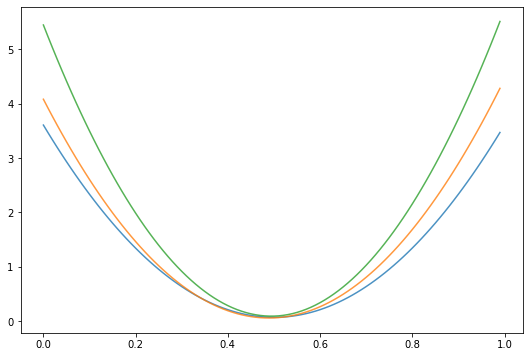

In [4]:
svec = np.arange(0, 1, 0.01) # m. longitudinal distance from end of quad triplet
bagxvec = bag_triplet(svec, ENG,
                        BETAX, ALPHAX, GAMMAX,
                        LQ1, GRAD1, LQ2, GRAD2, LDRIFT, 
                        fdf=['focus','defocus','focus'])
bagyvec = bag_triplet(svec, ENG,
                        BETAY, ALPHAY, GAMMAY,
                        LQ1, GRAD1, LQ2, GRAD2, LDRIFT, 
                        fdf=['defocus','focus','defocus'])


fig, ax = plt.subplots(figsize=(9,6))
ls = dict(linewidth=1.5,linestyle='-',alpha=0.8,ms=0,mfc='none')

xvec = svec
yvec = bagxvec[0]
ax.plot(xvec, yvec, **ls)

xvec = svec
yvec = bagyvec[0]
ax.plot(xvec, yvec, **ls)

xvec = svec
yvec = np.sqrt(bagxvec[0]**2 + bagyvec[0]**2)
ax.plot(xvec, yvec, **ls)

# xvec = svec
# yvec = bagxvec[0] + bagyvec[0]
# ax.plot(xvec, yvec, **ls)

In [5]:
s0 = 0.5 # point of focus

def fun_to_opt(lq1, g1, ld):
    """ Function to optimize. 
    """
    lq2 = 2 * lq1
    g2 = g1
    
    bagxvec = bag_triplet(s0, ENG,
                            BETAX, ALPHAX, GAMMAX,
                            lq1,g1,lq2,g2,ld, 
                            fdf=['focus','defocus','focus'])
    bagyvec = bag_triplet(s0, ENG,
                            BETAY, ALPHAY, GAMMAY,
                            lq1,g1,lq2,g2,ld,
                            fdf=['defocus','focus','defocus'])
    
    return bagxvec[0], np.abs(bagxvec[1]), bagyvec[0], np.abs(bagyvec[1])

fun_to_opt(LQ1,GRAD1,LDRIFT)
    

(0.07068354122956713,
 0.002015702660942753,
 0.06150528280860901,
 0.18519529993855038)

In [6]:
# define search space. space for initial particles.
ss = np.array([[0.05, 0.2],
                 [5, 300],
                 [0.005, 0.1]])
# define domain. values to stay inside at all times.
dd = np.array([[0.025, 0.5],
               [0, 500],
               [0, 0.5]])

# define target values
BETAX_TARGET = 0.07
ALPHAX_TARGET = 0.0
BETAY_TARGET = 0.07
ALPHAY_TARGET = 0.0

target = np.array([BETAX_TARGET, ALPHAX_TARGET, BETAY_TARGET, ALPHAY_TARGET])

# PSO parameters
nparticles = 8
maxiter = 111
precision = 1e-6

args = [ss, target, nparticles, maxiter, precision, dd]

opt = pso.PSO()
xarr, varr, parr, cparr, garr, cgarr = opt.run_pso(fun_to_opt, *args)
xarr.shape


optimization took  0.25 seconds


(8, 3, 113)

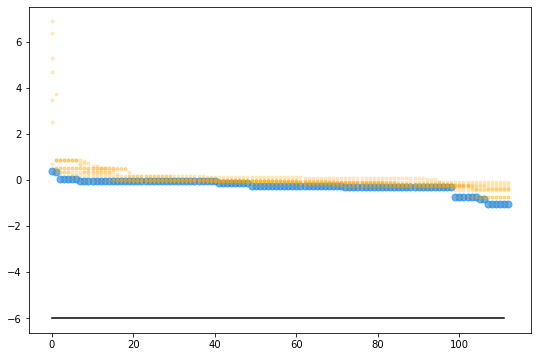

In [7]:
fig, ax = plt.subplots(figsize=(9,6))
xvec = np.log10(cgarr)
ls = dict(linewidth=0.0,linestyle='-',marker='o',ms=7,alpha=0.7,color='dodgerblue')
ax.plot(xvec,**ls)
xvec = [0,opt.maxiter]
yvec = np.log10([opt.precision, opt.precision])
ax.plot(xvec, yvec, 'k')
for i in range(nparticles):
    xvec = np.log10(cparr[i,:])
    ls = dict(linewidth=0.0,linestyle='-',marker='o',ms=3,alpha=0.2,color='orange')
    ax.plot(xvec, **ls)


# plt.axis([0,opt.maxiter, 0, 100*opt.precision])
plt.show()

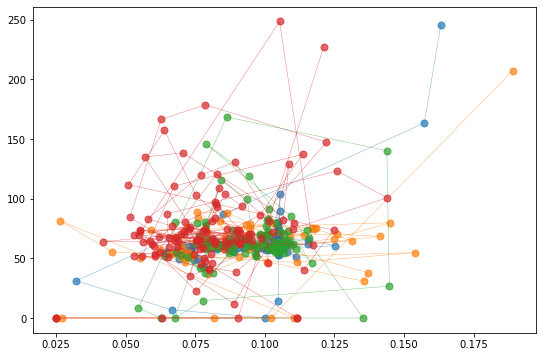

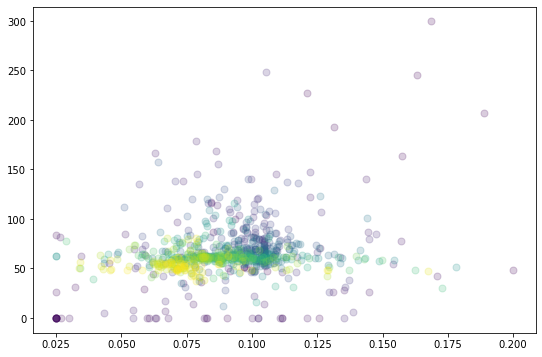

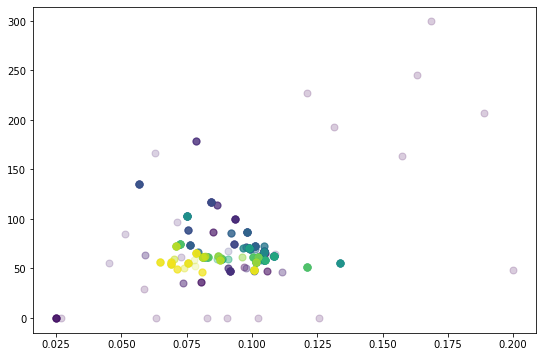

In [8]:
pr = np.array([0,0.1,0,250])
fig, ax = plt.subplots(figsize=(9,6))
for i in range(4):
    xvec = xarr[i,0,:]
    yvec = xarr[i,1,:]
    ls = dict(linewidth=0.4,linestyle='-',marker='o',alpha=0.7,ms=7)
    ax.plot(xvec,yvec,**ls)
# plt.axis(pr)

fig, ax = plt.subplots(figsize=(9,6))
ni = xarr.shape[2]
for i in range(ni):
    xvec = xarr[:,0,i]
    yvec = xarr[:,1,i]
    ls = dict(linewidth=0.0,linestyle='-',marker='o',ms=7,
              alpha=0.2,color=pso.rgb_color((i+1)/ni,cmapname='viridis'))
    ax.plot(xvec,yvec,**ls)
# plt.axis(pr)


fig, ax = plt.subplots(figsize=(9,6))
ni = xarr.shape[2]
for i in range(ni):
    xvec = parr[:,0,i]
    yvec = parr[:,1,i]
    ls = dict(linewidth=0.0,linestyle='-',marker='o',ms=7,
              alpha=0.2,color=pso.rgb_color((i+1)/ni,cmapname='viridis'))
    ax.plot(xvec,yvec,**ls)
# plt.axis(pr)

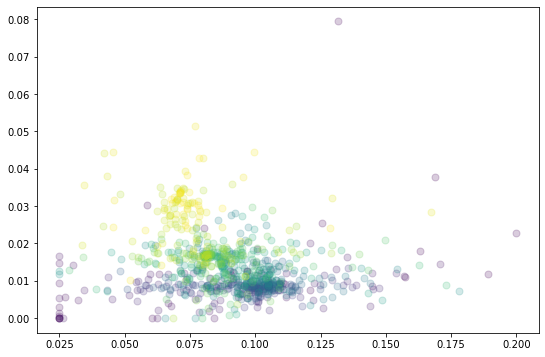

In [9]:
fig, ax = plt.subplots(figsize=(9,6))
ni = xarr.shape[2]
for i in range(ni):
    xvec = xarr[:,0,i]
    yvec = xarr[:,2,i]
    ls = dict(linewidth=0.0,linestyle='-',marker='o',ms=7,
              alpha=0.2,color=pso.rgb_color((i+1)/ni,cmapname='viridis'))
    ax.plot(xvec,yvec,**ls)